# Imports

In [67]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import io

# Download the Dataset

In [11]:
imdb, info  = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/pndx/tensorflow_datasets/imdb_reviews/plain_text/incomplete.AX21VL_1.0.0/imdb_reviews-train.tf…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/pndx/tensorflow_datasets/imdb_reviews/plain_text/incomplete.AX21VL_1.0.0/imdb_reviews-test.tfr…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/pndx/tensorflow_datasets/imdb_reviews/plain_text/incomplete.AX21VL_1.0.0/imdb_reviews-unsuperv…

Dataset imdb_reviews downloaded and prepared to /home/pndx/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2025-03-15 16:24:29.666446: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/home/pndx/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo 

In [13]:
print(imdb)

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


# Split the dataset

In [14]:
for example in imdb['train'].take(4):
    print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

2025-03-15 16:28:11.566045: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-15 16:28:11.575690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-15 16:28:11.576257: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
train_dataset, test_dataset = imdb['train'], imdb['test']

# Generate padded sequences

- Convert Strings to Integer Sequences
- Pad the Sequences to a Uniform Length

In [21]:
#params
VOCAB_SIZE = 10000
MAX_LENGTH = 120
EMBEDDING_DIM = 16
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

The vocabulary should be generated based only in the training set.

In [34]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)

#Get the string inputs and integer outputs of the training_set
train_reviews = train_dataset.map(lambda review, label: review)
train_labels = train_dataset.map(lambda review, label: label)

#Get the string inputs and integer outputs of the test_set
test_reviews = test_dataset.map(lambda review, label: review)
test_labels = test_dataset.map(lambda review, label: label)

#Generate the vocabulary based only on the training_set
vectorize_layer.adapt(train_reviews)

In [40]:
def padding_func(sequences):
    '''Generates padded sequences from a tf.data.Dataset'''

    # put all elements in a single ragged batch
    sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

    # output a tensor from the single batch
    sequences = sequences.get_single_element()

    # pad the sequences
    # the pad_sequences function expects an iterable, while the input of this function is
    # a td.data.Dataset.

    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                    maxlen=MAX_LENGTH,
                                                    truncating=TRUNC_TYPE,
                                                    padding=PADDING_TYPE)
    
    # convert back to a tf.data.Dataset
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    
    return padded_sequences
    

In [42]:
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)
test_sequences = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

2025-03-16 15:50:13.893600: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46573608 exceeds 10% of free system memory.
2025-03-16 15:50:17.259980: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45527768 exceeds 10% of free system memory.


In [45]:
for example in train_sequences.take(1):
    print(example)

tf.Tensor(
[   0    0    0    0   11   14   34  412  384   18   90   28    1    8
   33 1322 3560   42  487    1  191   24   85  152   19   11  217  316
   28   65  240  214    8  489   54   65   85  112   96   22 5596   11
   93  642  743   11   18    7   34  394 9522  170 2464  408    2   88
 1216  137   66  144   51    2    1 7558   66  245   65 2870   16    1
 2860    1    1 1426 5050    3   40    1 1579   17 3560   14  158   19
    4 1216  891 8040    8    4   18   12   14 4059    5   99  146 1241
   10  237  704   12   48   24   93   39   11 7339  152   39 1322    1
   50  398   10   96 1155  851  141    9], shape=(120,), dtype=int32)


2025-03-16 15:51:15.700209: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences, train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences, test_labels)

In [57]:
for example in train_dataset_vectorized.take(1):
    print(example)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


optimize and batch the datasets

In [58]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                       )

# Build and compile the model

In [64]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │        11,526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [65]:
NUM_EPOCHS = 5

history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6374 - loss: 0.6076 - val_accuracy: 0.8261 - val_loss: 0.3830
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8793 - loss: 0.2906 - val_accuracy: 0.8226 - val_loss: 0.4143
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9519 - loss: 0.1445 - val_accuracy: 0.7986 - val_loss: 0.5353
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9904 - loss: 0.0452 - val_accuracy: 0.8085 - val_loss: 0.5950
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9971 - loss: 0.0143 - val_accuracy: 0.8071 - val_loss: 0.6741


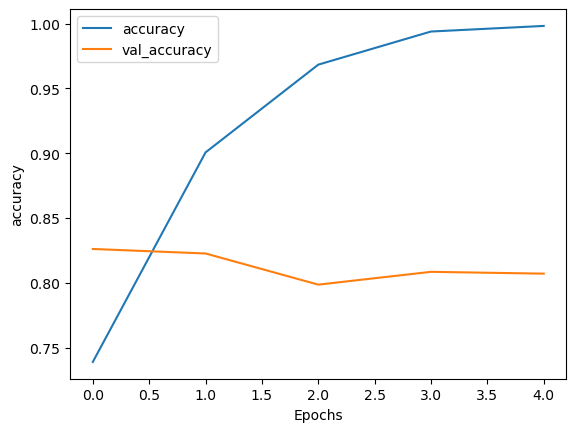

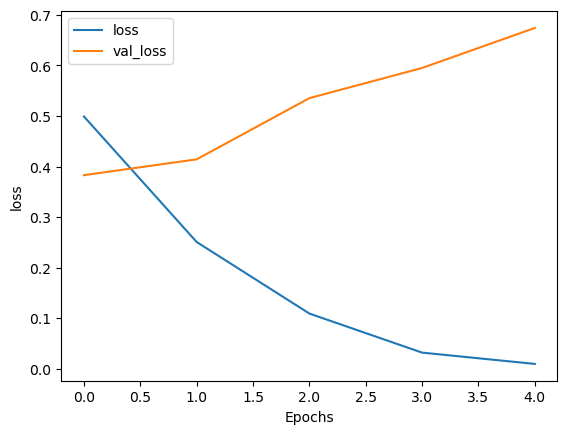

In [68]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")